In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, uint64, byte, types, float64, float32
from scipy.ndimage.filters import gaussian_filter 

font = Image.open("font-distance.png")
fontarr = np.array(font)
sy,sx,_ = fontarr.shape
fy,fx = sy//16, sx//16
fontarr = [fontarr[fy*i:fy*(i+1), fx*j:fx*(j+1), :] for i in range(16) for j in range(16)]
fontdist = [d[:,:,3].astype(np.float32)/255-0.5 for d in fontarr]

def getfontdist(c): 
    return fontdist[ord(c)]

def getstrdist(s:str):
    fds = [*map(getfontdist, s)]
    sy,sx = fds[0].shape
    nw = 0.4
    sxl = int((nw/2)*sx); sxh = sx-sxl
    fds = [d[:,sxl:sxh] for d in fds]
    sx = sxh - sxl
    arr = np.zeros((sy,sx*len(s)))
    for i,fd in enumerate(fds):
        arr[:,i*sx:(i+1)*sx] = fd
    return arr

def scalefield(field256, scale):
    sy,sx = field256.shape
    sy,sx = sy*scale, sx*scale
    return np.array(Image.fromarray(field256).resize((sx,sy), resample=Image.Resampling.BILINEAR))

@jit(float32[:,:](float32[:,:]))
def gradientfield(field):
    dfield = np.ones(field.shape, dtype=np.float32)
    for y in range(1,field.shape[0]-1):
        for x in range(1,field.shape[1]-1):
            dy = (field[y+1,x] - field[y-1,x])/2
            dx = (field[y,x+1] - field[y,x-1])/2
            dfield[y,x] = (dy*dy + dx*dx)**0.5
    return dfield

def fieldtocontour(field, interval, width, noise=5):
    nfield = gaussian_filter(field, noise, mode='constant')
    nfield = nfield % interval
    dfield = gradientfield(nfield)
    return (abs(nfield)/dfield <= width)

In [4]:
# https://prideout.net/blog/distance_fields/
# https://pythonhosted.org/scikit-fmm/

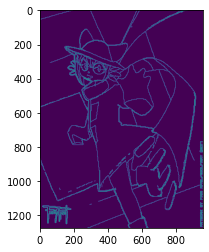

In [112]:
from skimage import feature
alula = Image.open("niko.webp")
edges = feature.canny(np.array(alula)[:,:,0], sigma=0.2)[3:-3,3:-3]
fill = (np.array(alula)[:,:,0][3:-3,3:-3] > 128)
poly = edges #^ fill
plt.imshow(poly)

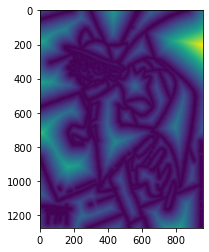

In [113]:
import skfmm
ds = skfmm.distance(0.5-poly.astype(np.float32), dx=1)
ds /= ds.max()
ds -= 0.5
plt.imshow(ds)

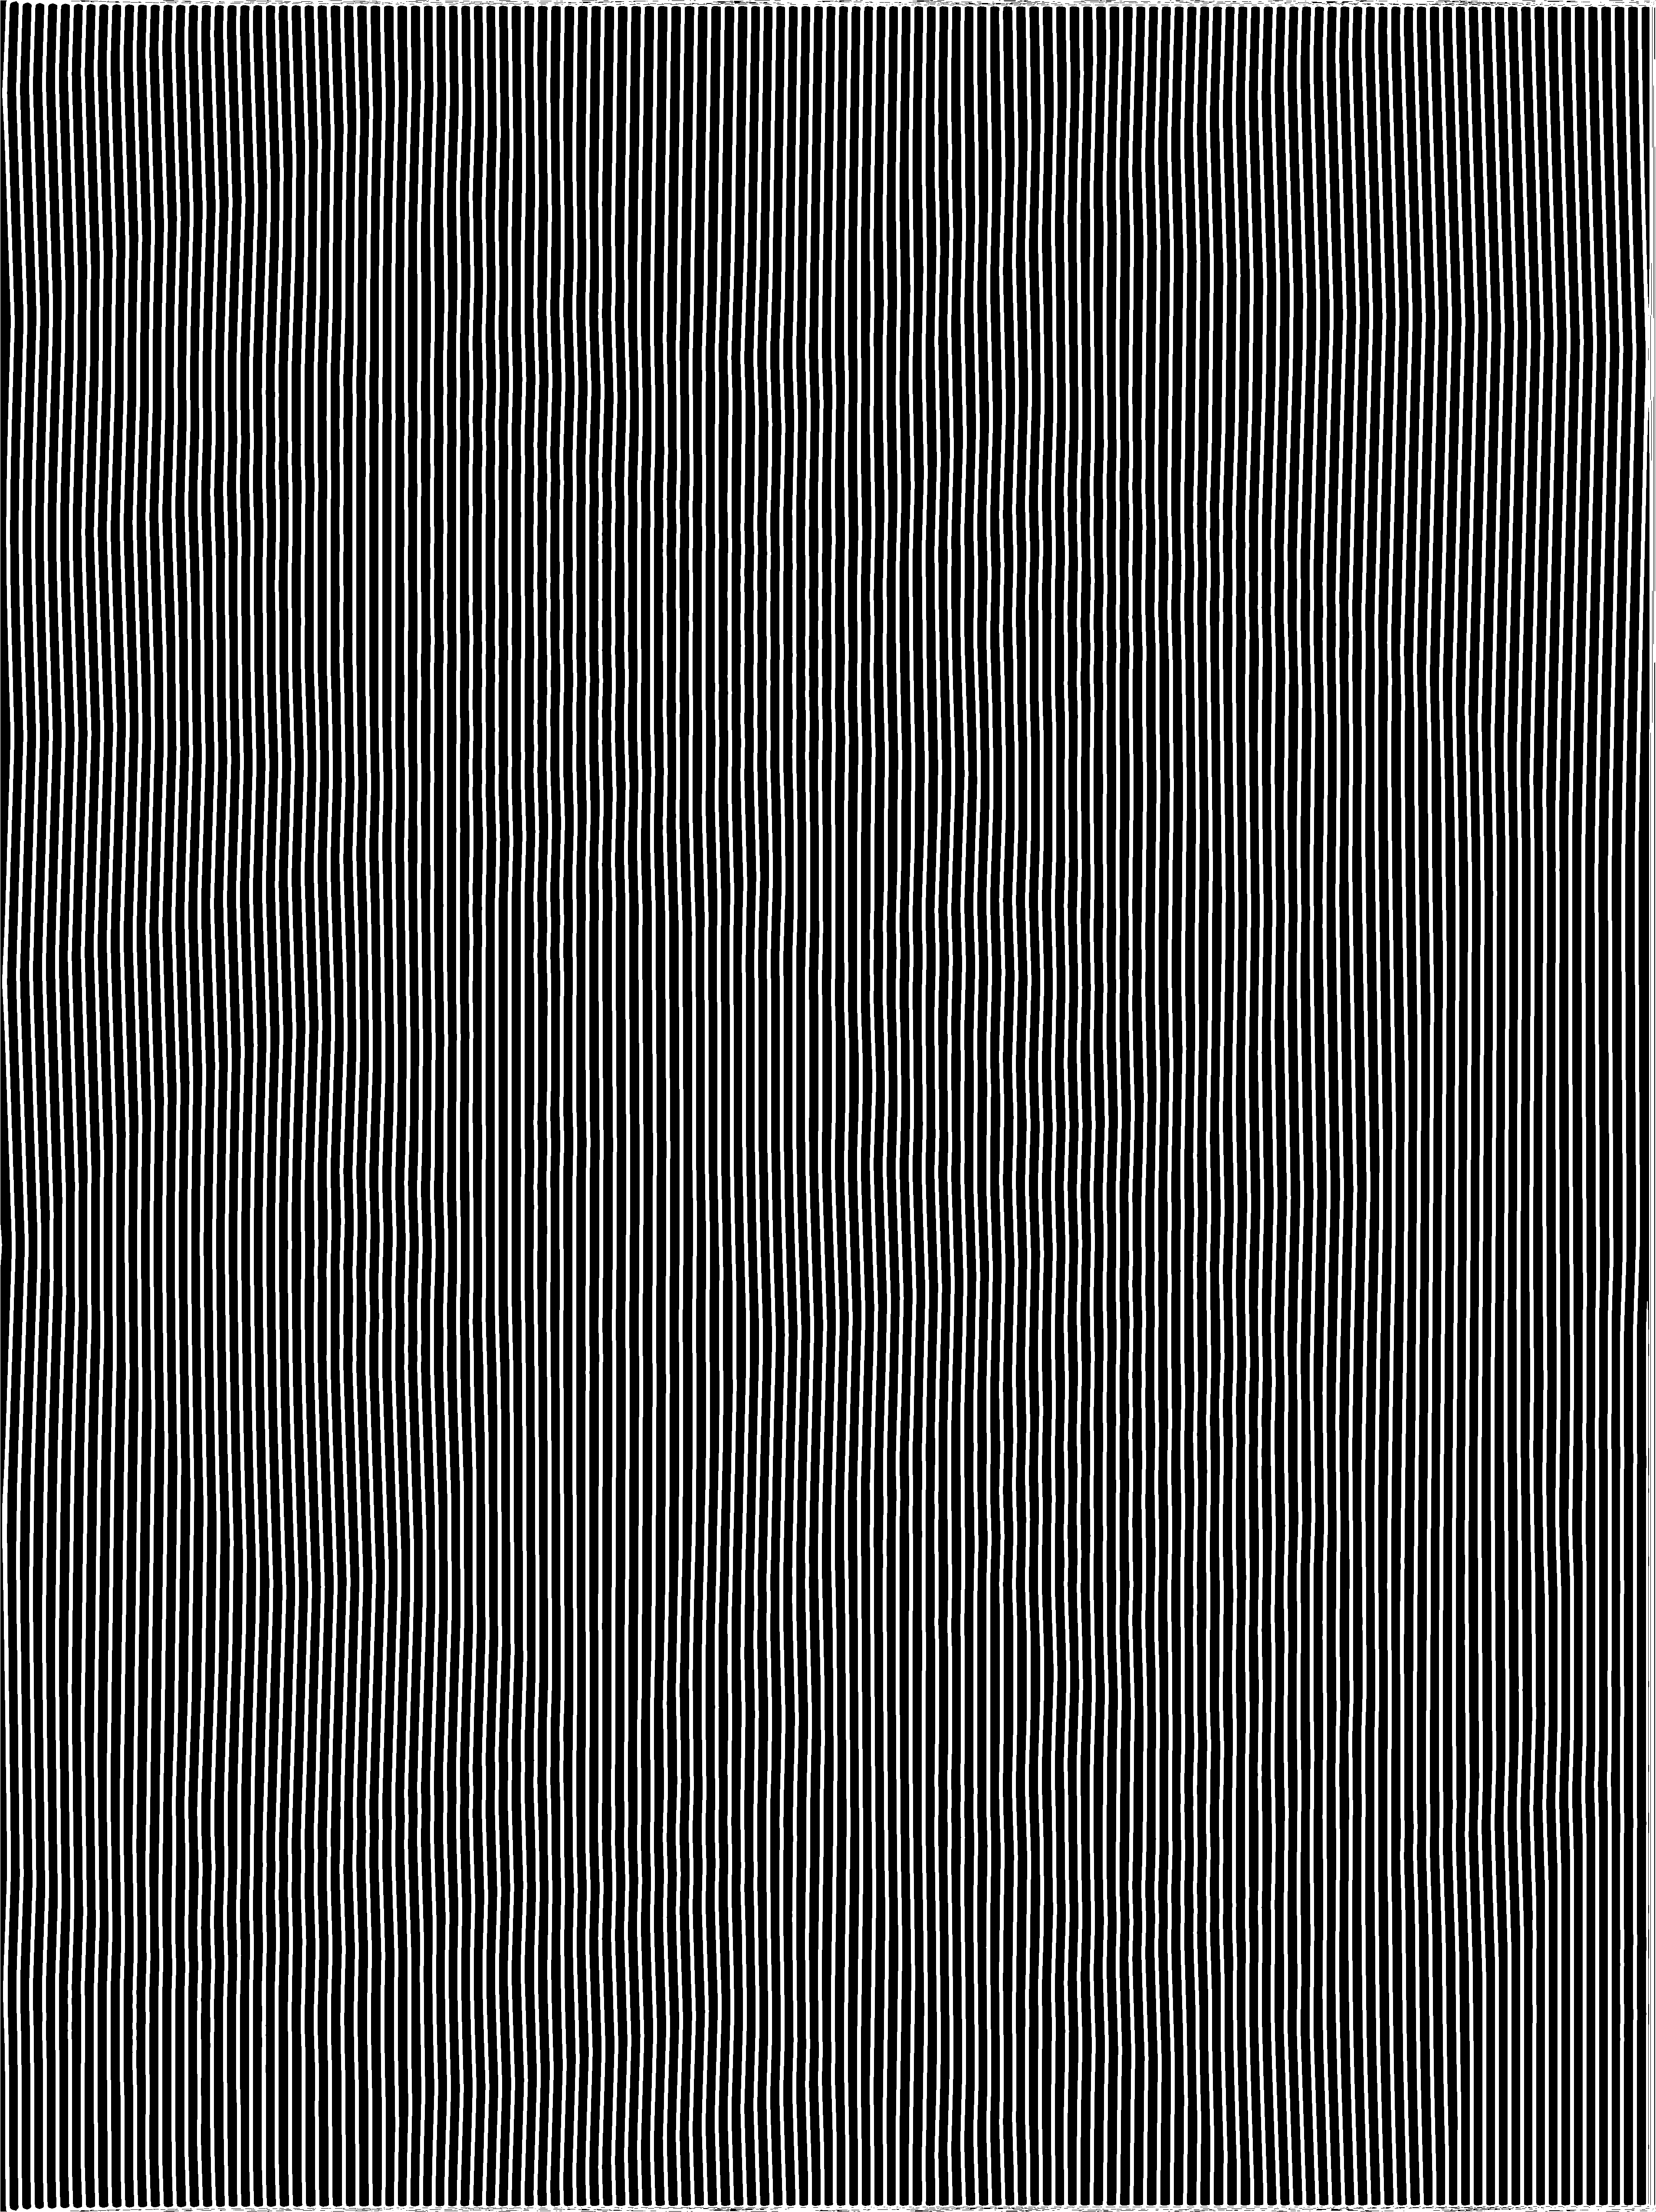

In [114]:
fd = scalefield(ds, 4)
gradx = np.linspace(0, 32*4, num=fd.shape[1])
for y in range(fd.shape[0]): fd[y,:] -= gradx
contour = fieldtocontour(fd, 1, 8)
img = Image.fromarray(contour)
img

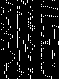

In [110]:
sx,sy = img.size
s = 64
img.resize((int(sx/s), int(sy/s)), resample=Image.Resampling.NEAREST)

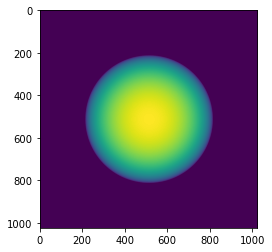

In [18]:
import skfmm

@jit(float32[:,:]())
def _genfield():
    s = 1024
    ds = np.zeros((s,s), dtype=np.float32)
    r = 300
    p = (s - 2*r)//2
    for x in range(2*r):
        for y in range(2*r):
            z = r*r - (x-r)*(x-r) - (y-r)*(y-r)
            z = float(max(z, 0))**0.5
            z /= float(r)
            ds[x+p,y+p] = z
    return ds

ds = _genfield()     
ds /= ds.max()
ds -= 0.5
plt.imshow(ds)

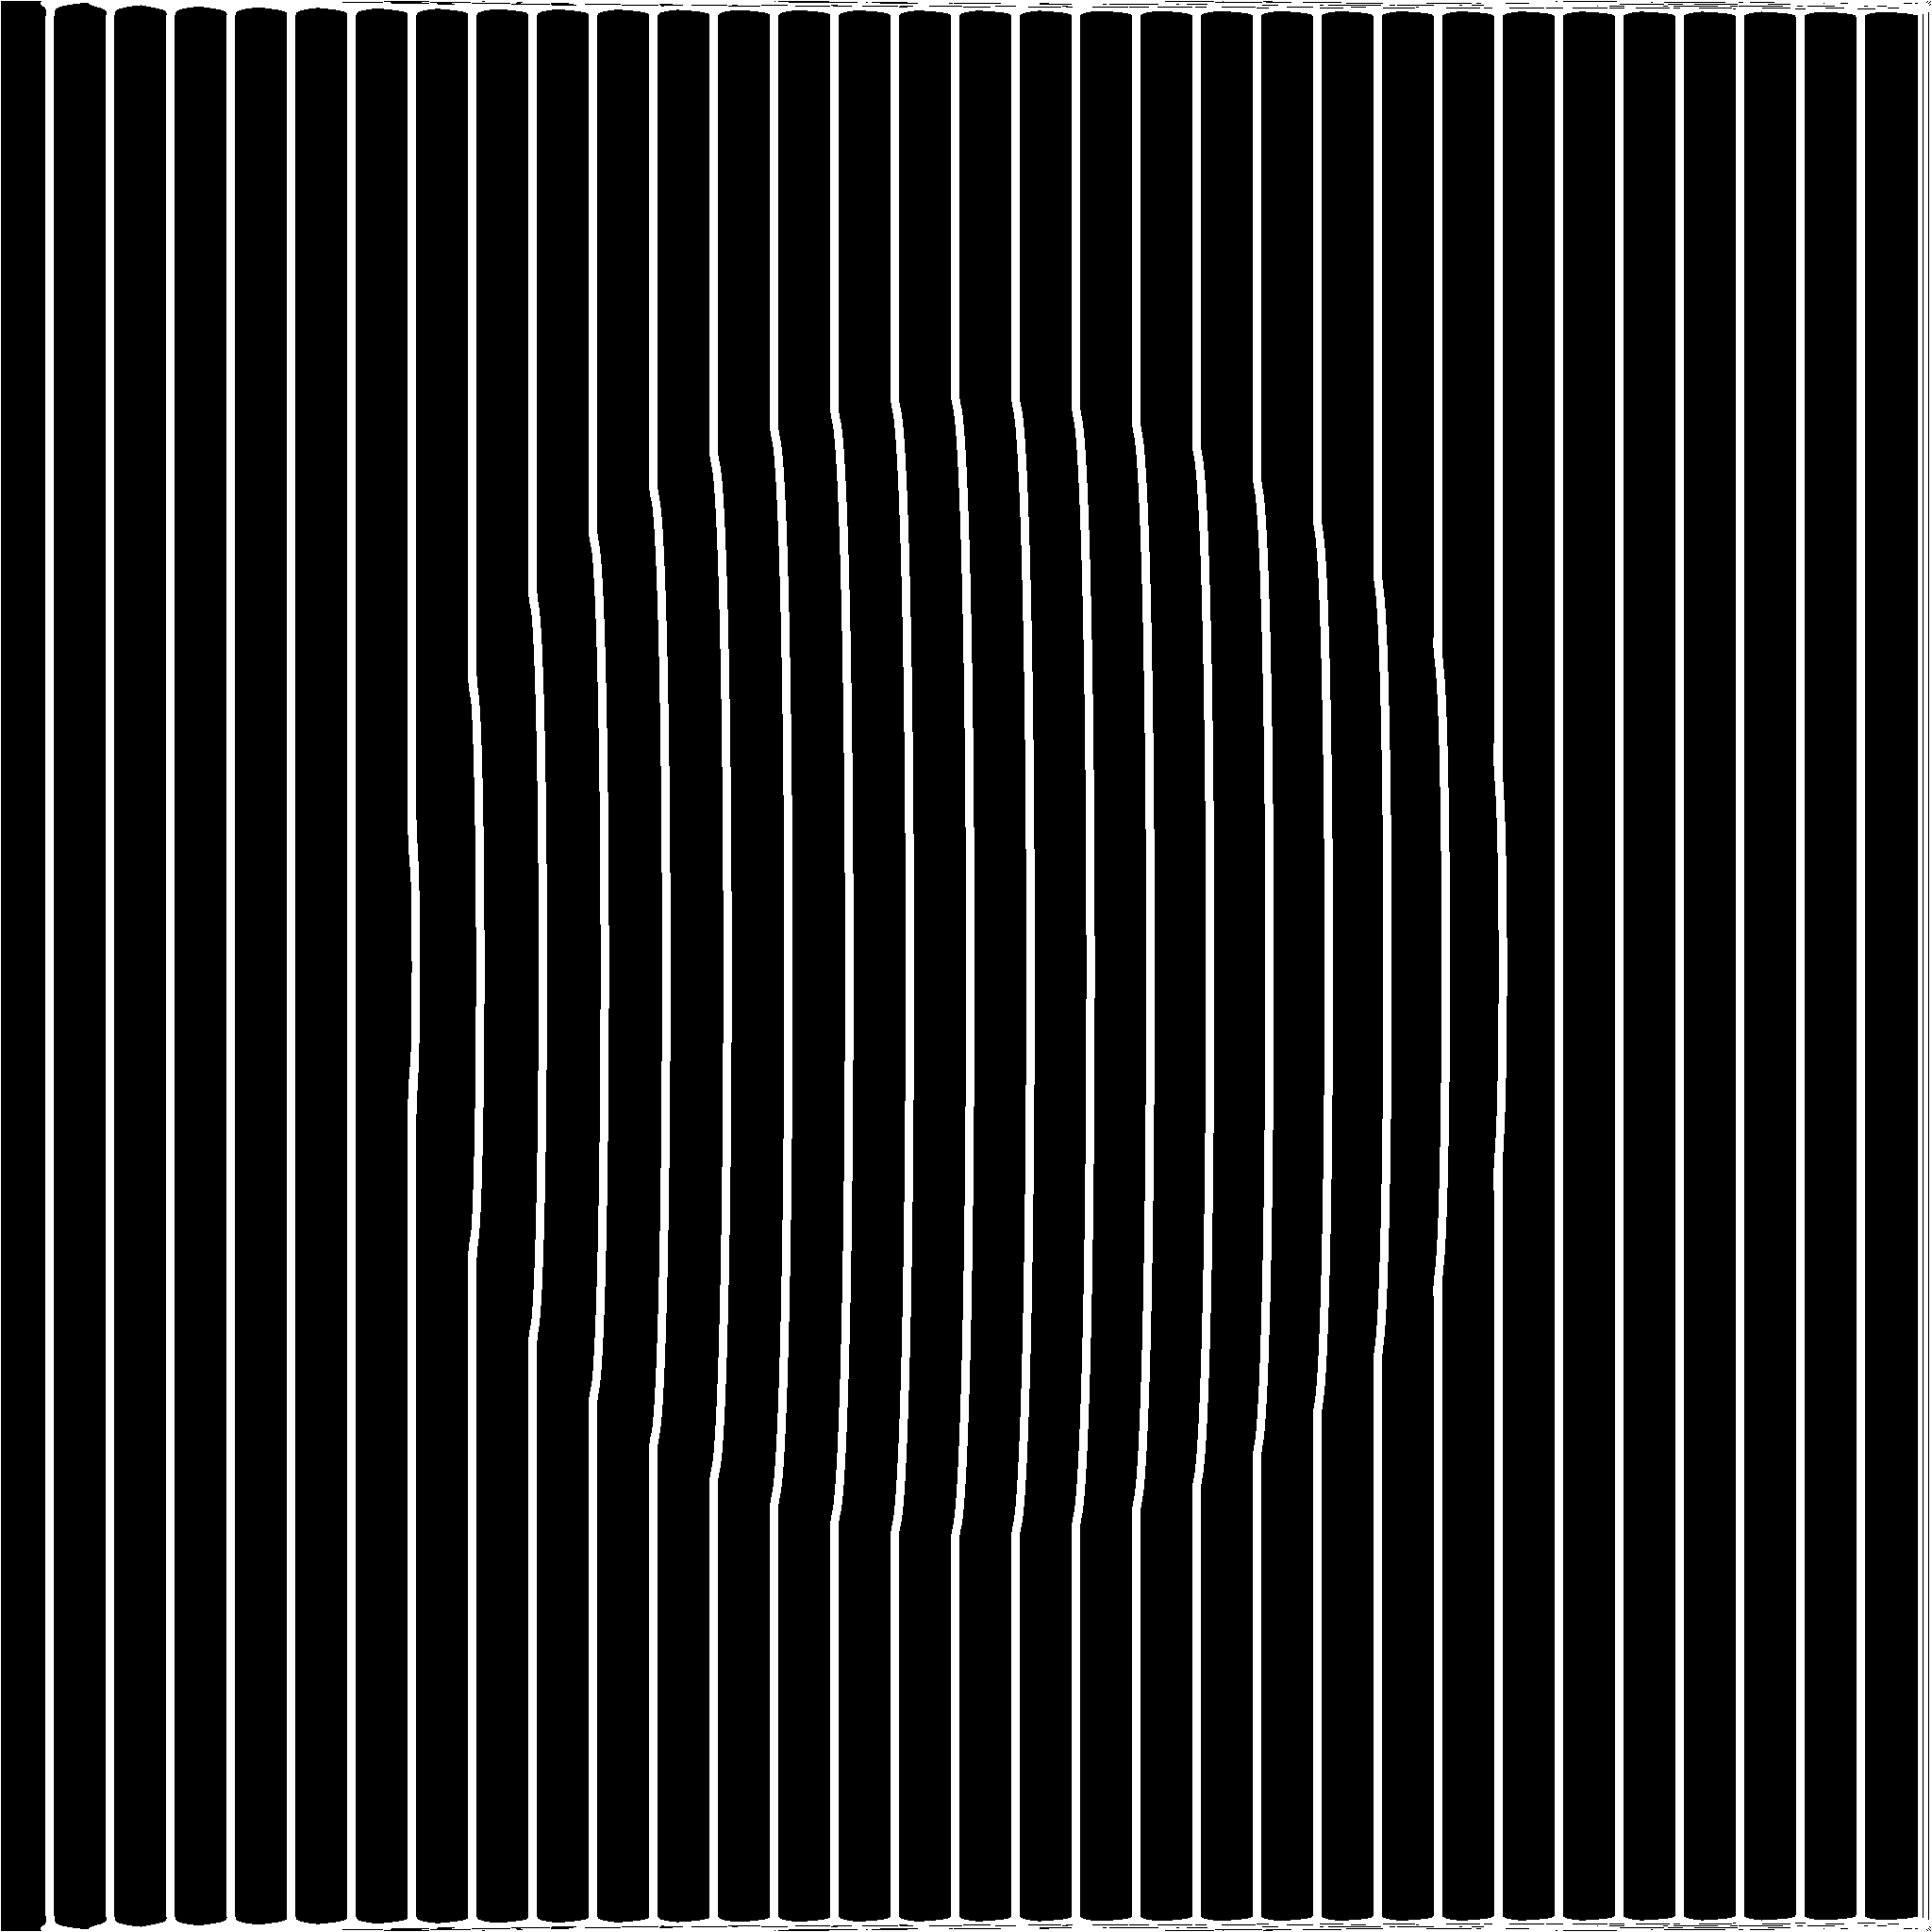

In [21]:
fd = scalefield(ds, 2)
gradx = np.linspace(0, 32*4, num=fd.shape[1])
for y in range(fd.shape[0]): fd[y,:] -= gradx
contour = fieldtocontour(fd, 4, 8)
img = Image.fromarray(contour)
img

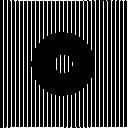

In [20]:
sx,sy = img.size
s = 16
img.resize((int(sx/s), int(sy/s)), resample=Image.Resampling.BICUBIC)

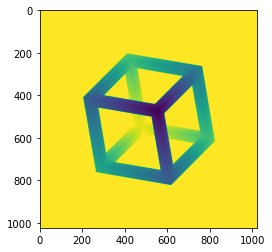

In [478]:
import skfmm

@jit(float32(float32, float32, float32))
def _length(x,y,z):
    return (x*x + y*y + z*z)**0.5

@jit(float32(float32, float32, float32))
def _sdbox(x,y,z):
    q = (abs(x) - 1, abs(y) - 1, abs(z) - 1)
    q1 = (max(q[0], 0), max(q[1], 0), max(q[2], 0))
    d = min(max(q[0],max(q[1],q[2])),0.0)
    return (q1[0]*q1[0] + q1[1]*q1[1] + q1[2]*q1[2])**0.5 + d

@jit(float32(float32, float32, float32))
def _sdboxframe(x,y,z):
    e = .1
    s = 1
    p = (abs(x) - s, abs(y) - s, abs(z) - s)
    x,y,z = p
    q = (abs(x+e)-e, abs(y+e)-e, abs(z+e)-e)
    return min(min(
      _length(max(p[0], 0), max(q[1], 0), max(q[2], 0))+min(max(p[0],max(q[1],q[2])),0.0),
      _length(max(q[0], 0), max(p[1], 0), max(q[2], 0))+min(max(q[0],max(p[1],q[2])),0.0)),
      _length(max(q[0], 0), max(q[1], 0), max(p[2], 0))+min(max(q[0],max(q[1],p[2])),0.0))

a1, a2, a3 = 0.785, 0.785, 0.785
c1,s1,c2,s2,c3,s3 = np.cos(a1), np.sin(a1), np.cos(a2), np.sin(a2), np.cos(a3), np.sin(a3)
@jit(float32(float32, float32, float32))
def _sdobj(x,y,z):
    z -= 1.5
    _x = x*c1 + y*s1
    _y = x*s1 - y*c1
    x,y = _x,_y
    _y = y*c2 + z*s2
    _z = y*s2 - z*c2
    y,z = _y,_z
    _x = x*c3 + z*s3
    _z = x*s3 - z*c3
    x,z = _x,_z
    return _sdboxframe(x,y,z)

@jit(float32[:,:]())
def _genfield():
    s = 1024
    w = 5.0
    z = 4.0
    ds = np.zeros((s,s), dtype=np.float32)
    for _x in range(s):
        for _y in range(s):
            x = _x/s - 0.5
            y = _y/s - 0.5
            x *= w; y *= w
            nz = z
            for i in range(200):
                d = _sdobj(x,y,nz)
                nz -= d
                if d < 0.01: break
            nz = max(0.0, nz)
            ds[_x,_y] = z-nz
    return ds

ds = _genfield()     
ds /= ds.max()
ds -= 0.5
plt.imshow(ds)

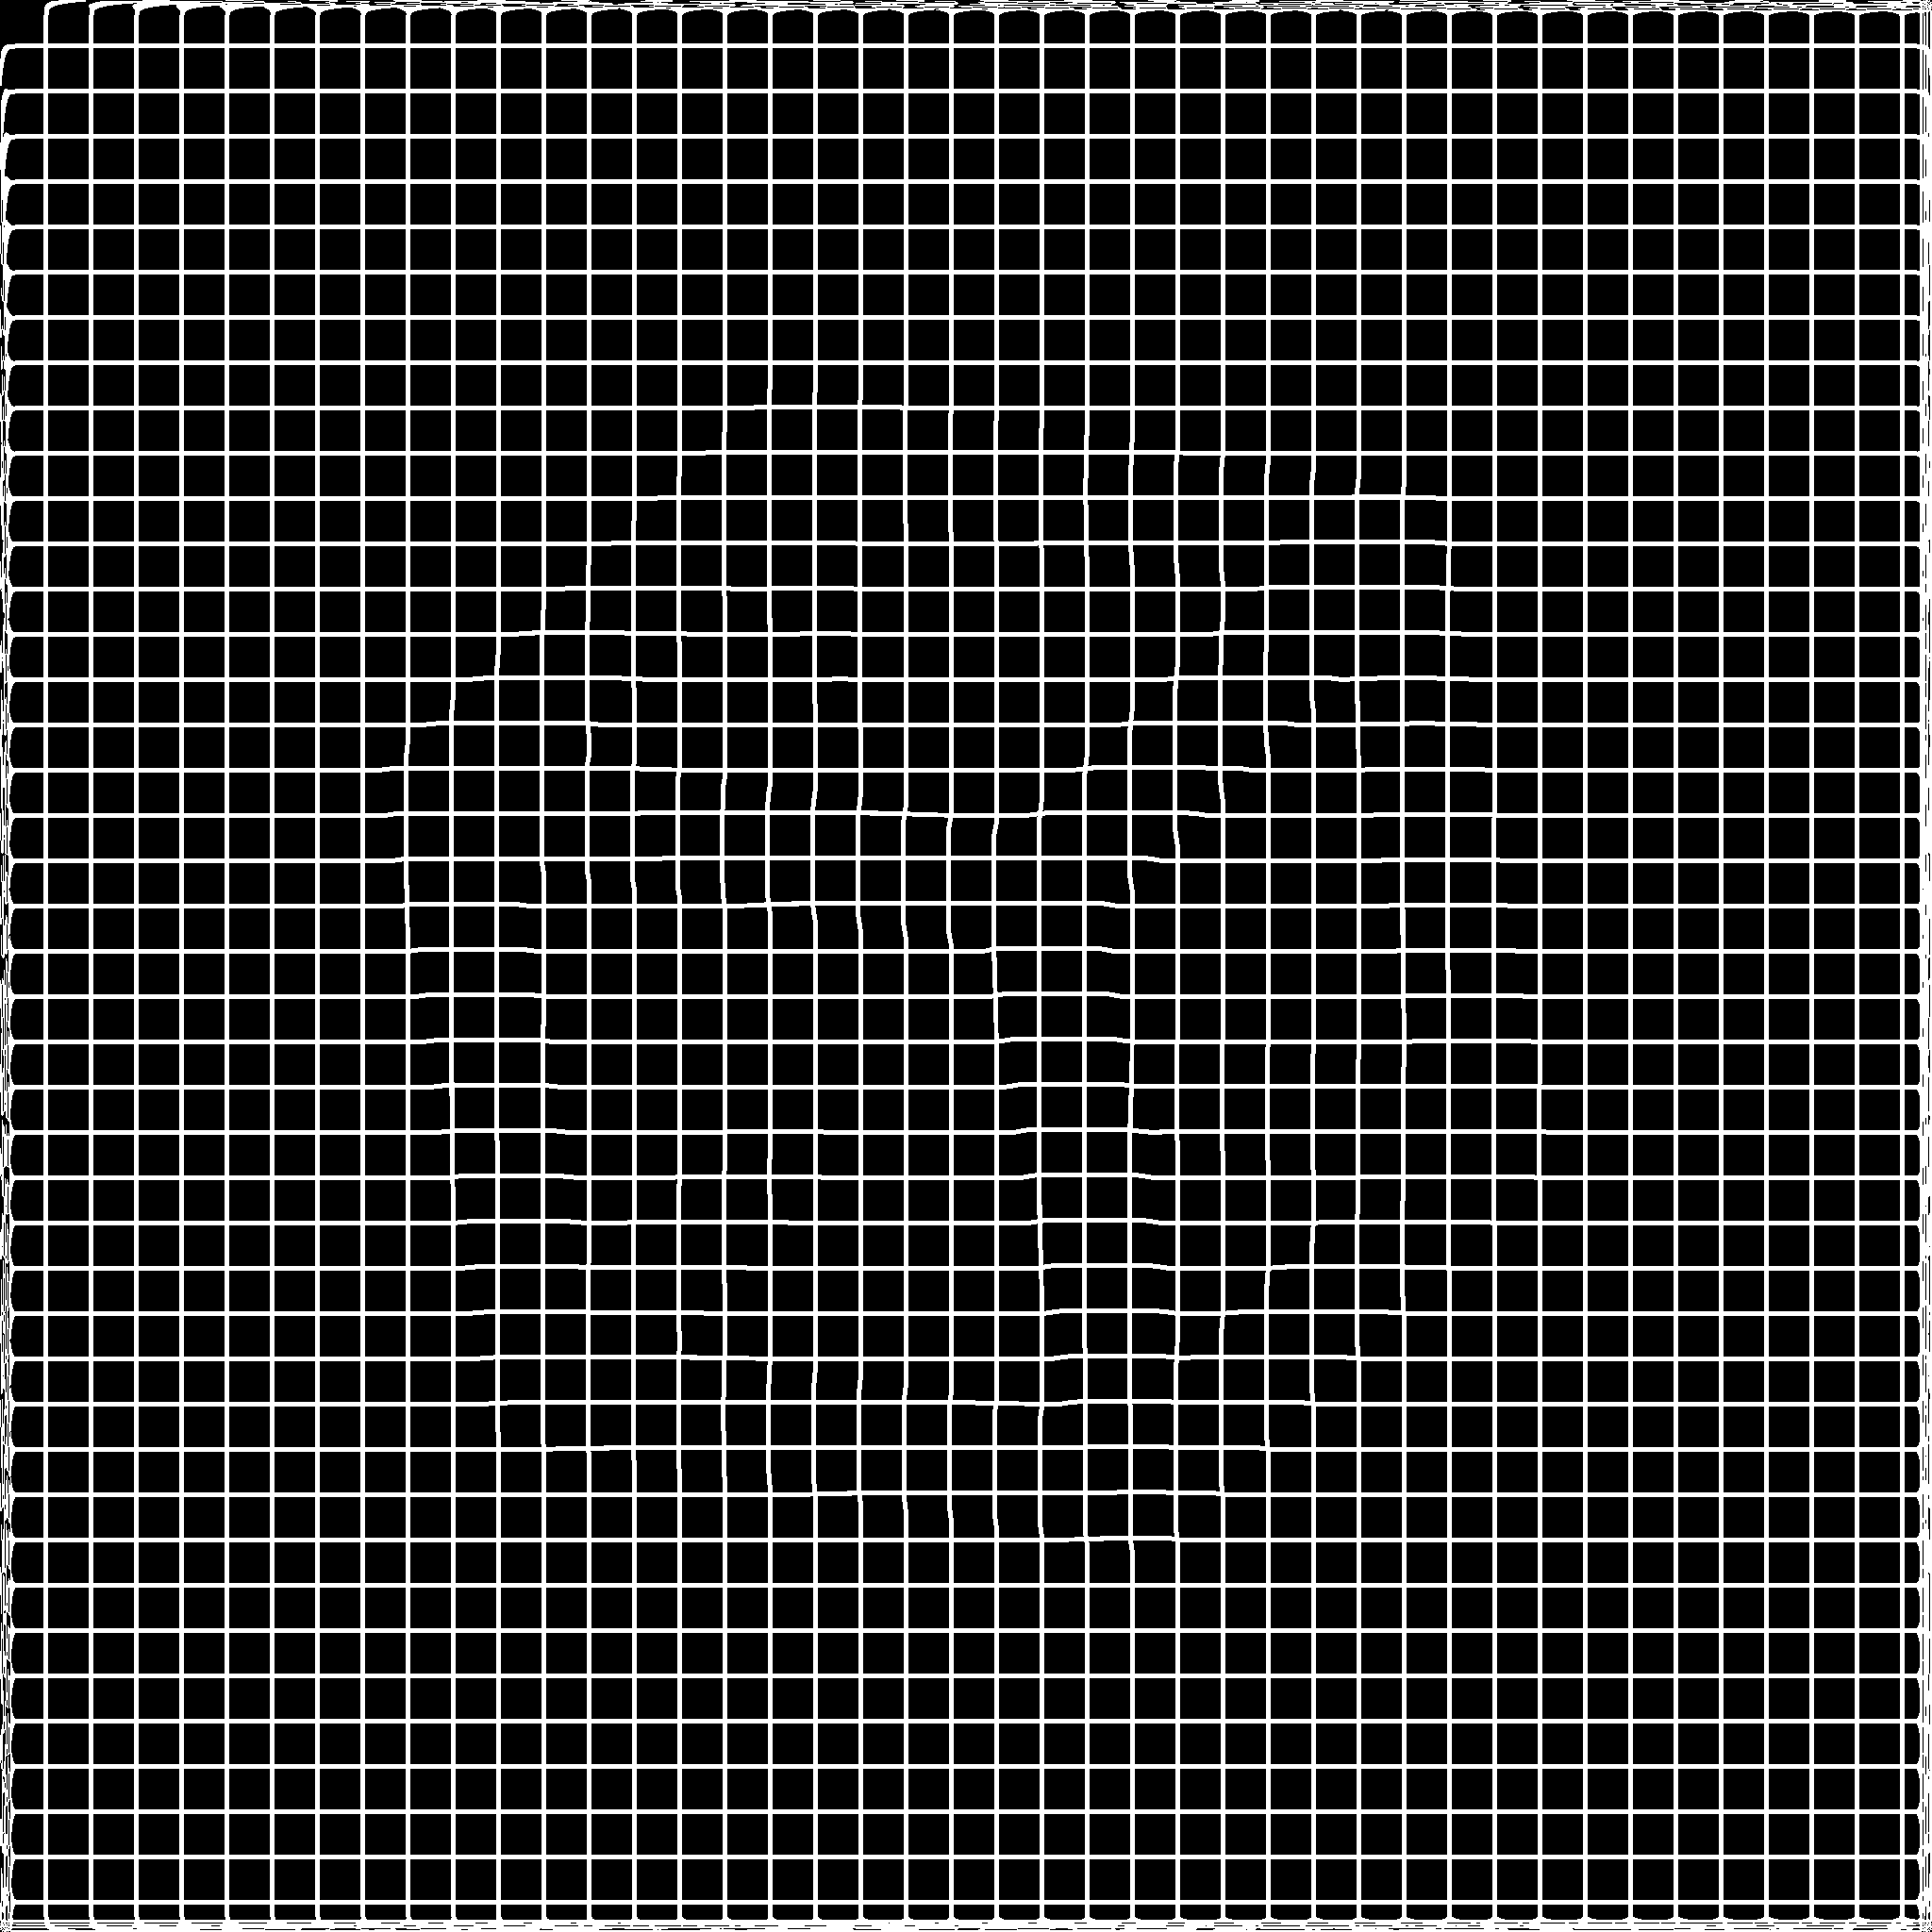

In [486]:
fd = scalefield(ds, 2)
gradx = np.linspace(0, 32*16, num=fd.shape[1])
fd2 = fd.copy()
for y in range(fd.shape[0]): fd2[y,:] -= gradx
contour = fieldtocontour(fd2, 12, 4)

grady = np.linspace(0, 32*16, num=fd.shape[0])
for x in range(fd.shape[1]): fd[:,x] -= grady
contour |= fieldtocontour(fd, 12, 4)

#fd2 = fd * 0
#gradx = np.linspace(0, 32*16, num=fd.shape[1])+1
#for y in range(fd.shape[0]): fd2[y,:] -= gradx
#contour |= fieldtocontour(fd2, 12/8, 4)

img = Image.fromarray(contour)
img

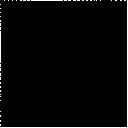

In [124]:
sx,sy = img.size
s = 16
img.resize((int(sx/s), int(sy/s)), resample=Image.Resampling.BICUBIC)

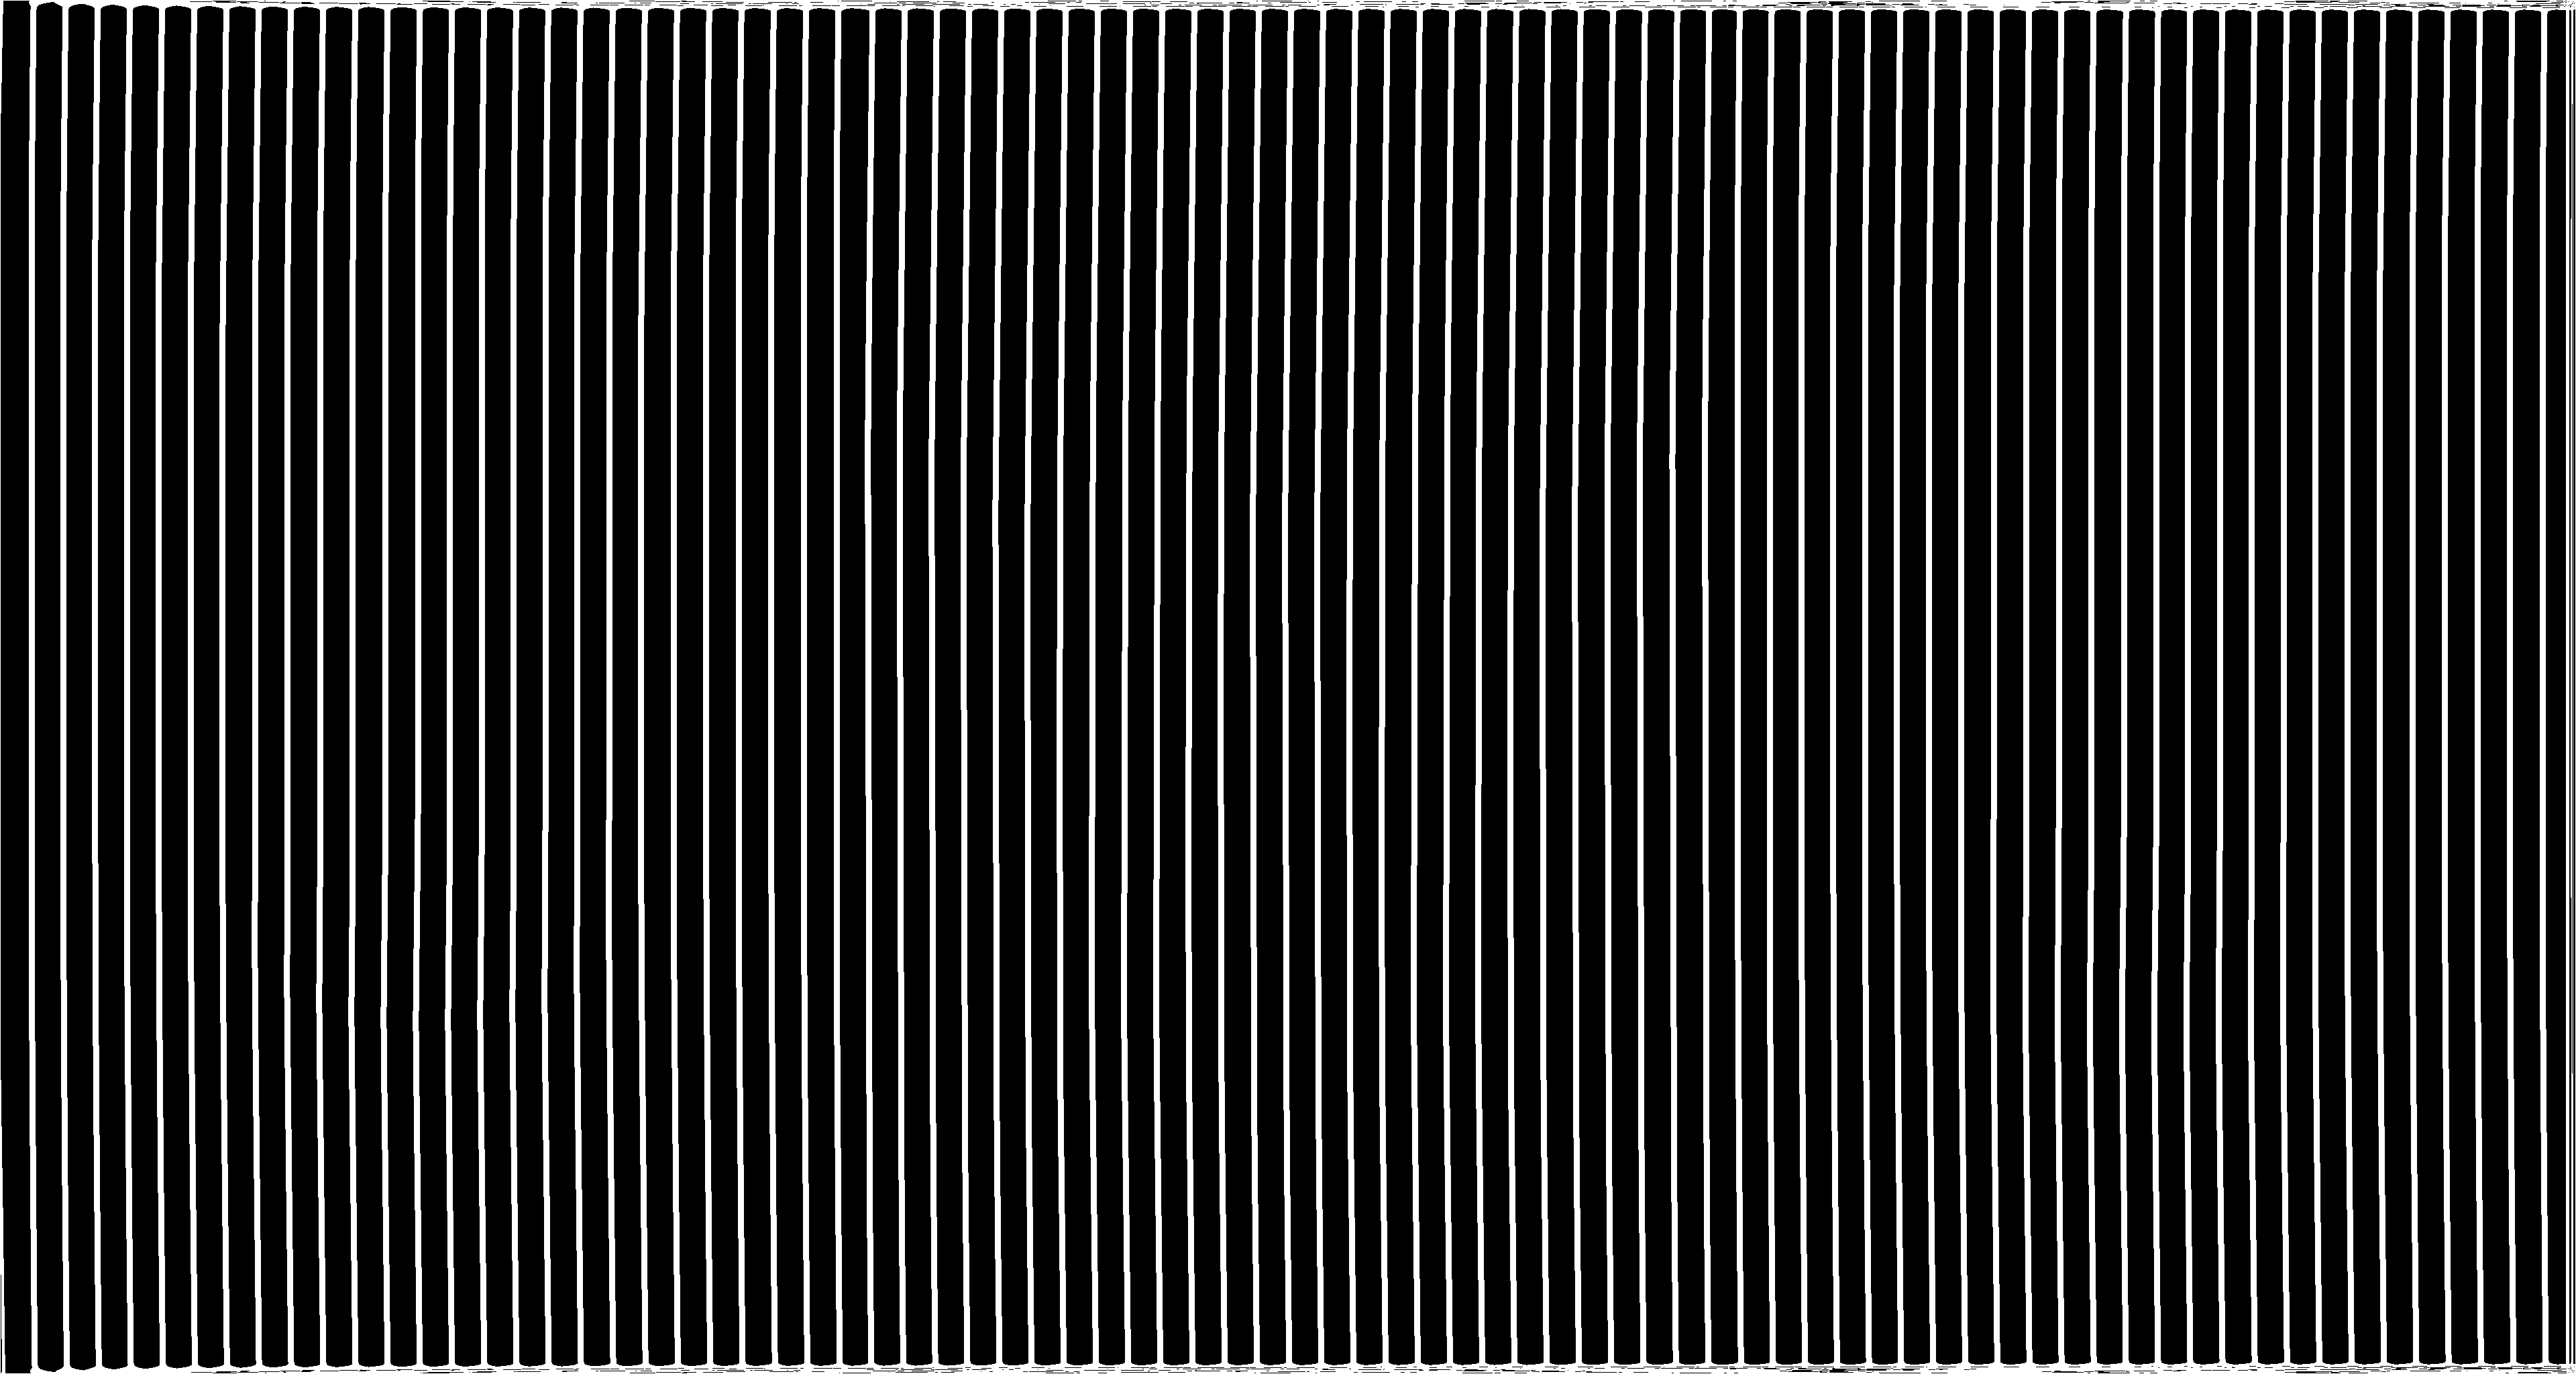

In [268]:
string = 'UwU'
fd = scalefield(getstrdist(string), 32)
gradx = np.linspace(0, int(32/0.6*len(string)), num=fd.shape[1])
for y in range(fd.shape[0]): fd[y,:] -= gradx
contour = fieldtocontour(fd, 2, 8)
img = Image.fromarray(contour)
img

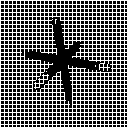

In [63]:
sx,sy = img.size
s = 16
img.resize((int(sx/s), int(sy/s)), resample=Image.Resampling.BICUBIC)

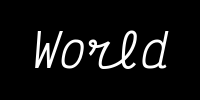

In [245]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

s1 = "Hello"
s2 = "World"
l = 100
H,W = l, int(l*len(s1)*0.4)
font = ImageFont.truetype("VictorMono-Italic.ttf", 50)

img1 = Image.fromarray(np.zeros((H,W), dtype=np.uint8))
draw = ImageDraw.Draw(img1)
_,_h,w,h = draw.textbbox((0,0), text=s1, font=font); h += _h
draw.text(((W-w)/2,(H-h)/2), s1, 255, font=font)

img2 = Image.fromarray(np.zeros((H,W), dtype=np.uint8))
draw = ImageDraw.Draw(img2)
_,_h,w,h = draw.textbbox((0,0), text=s2, font=font); h += _h
draw.text(((W-w)/2,(H-h)/2), s2, 255, font=font)

img2

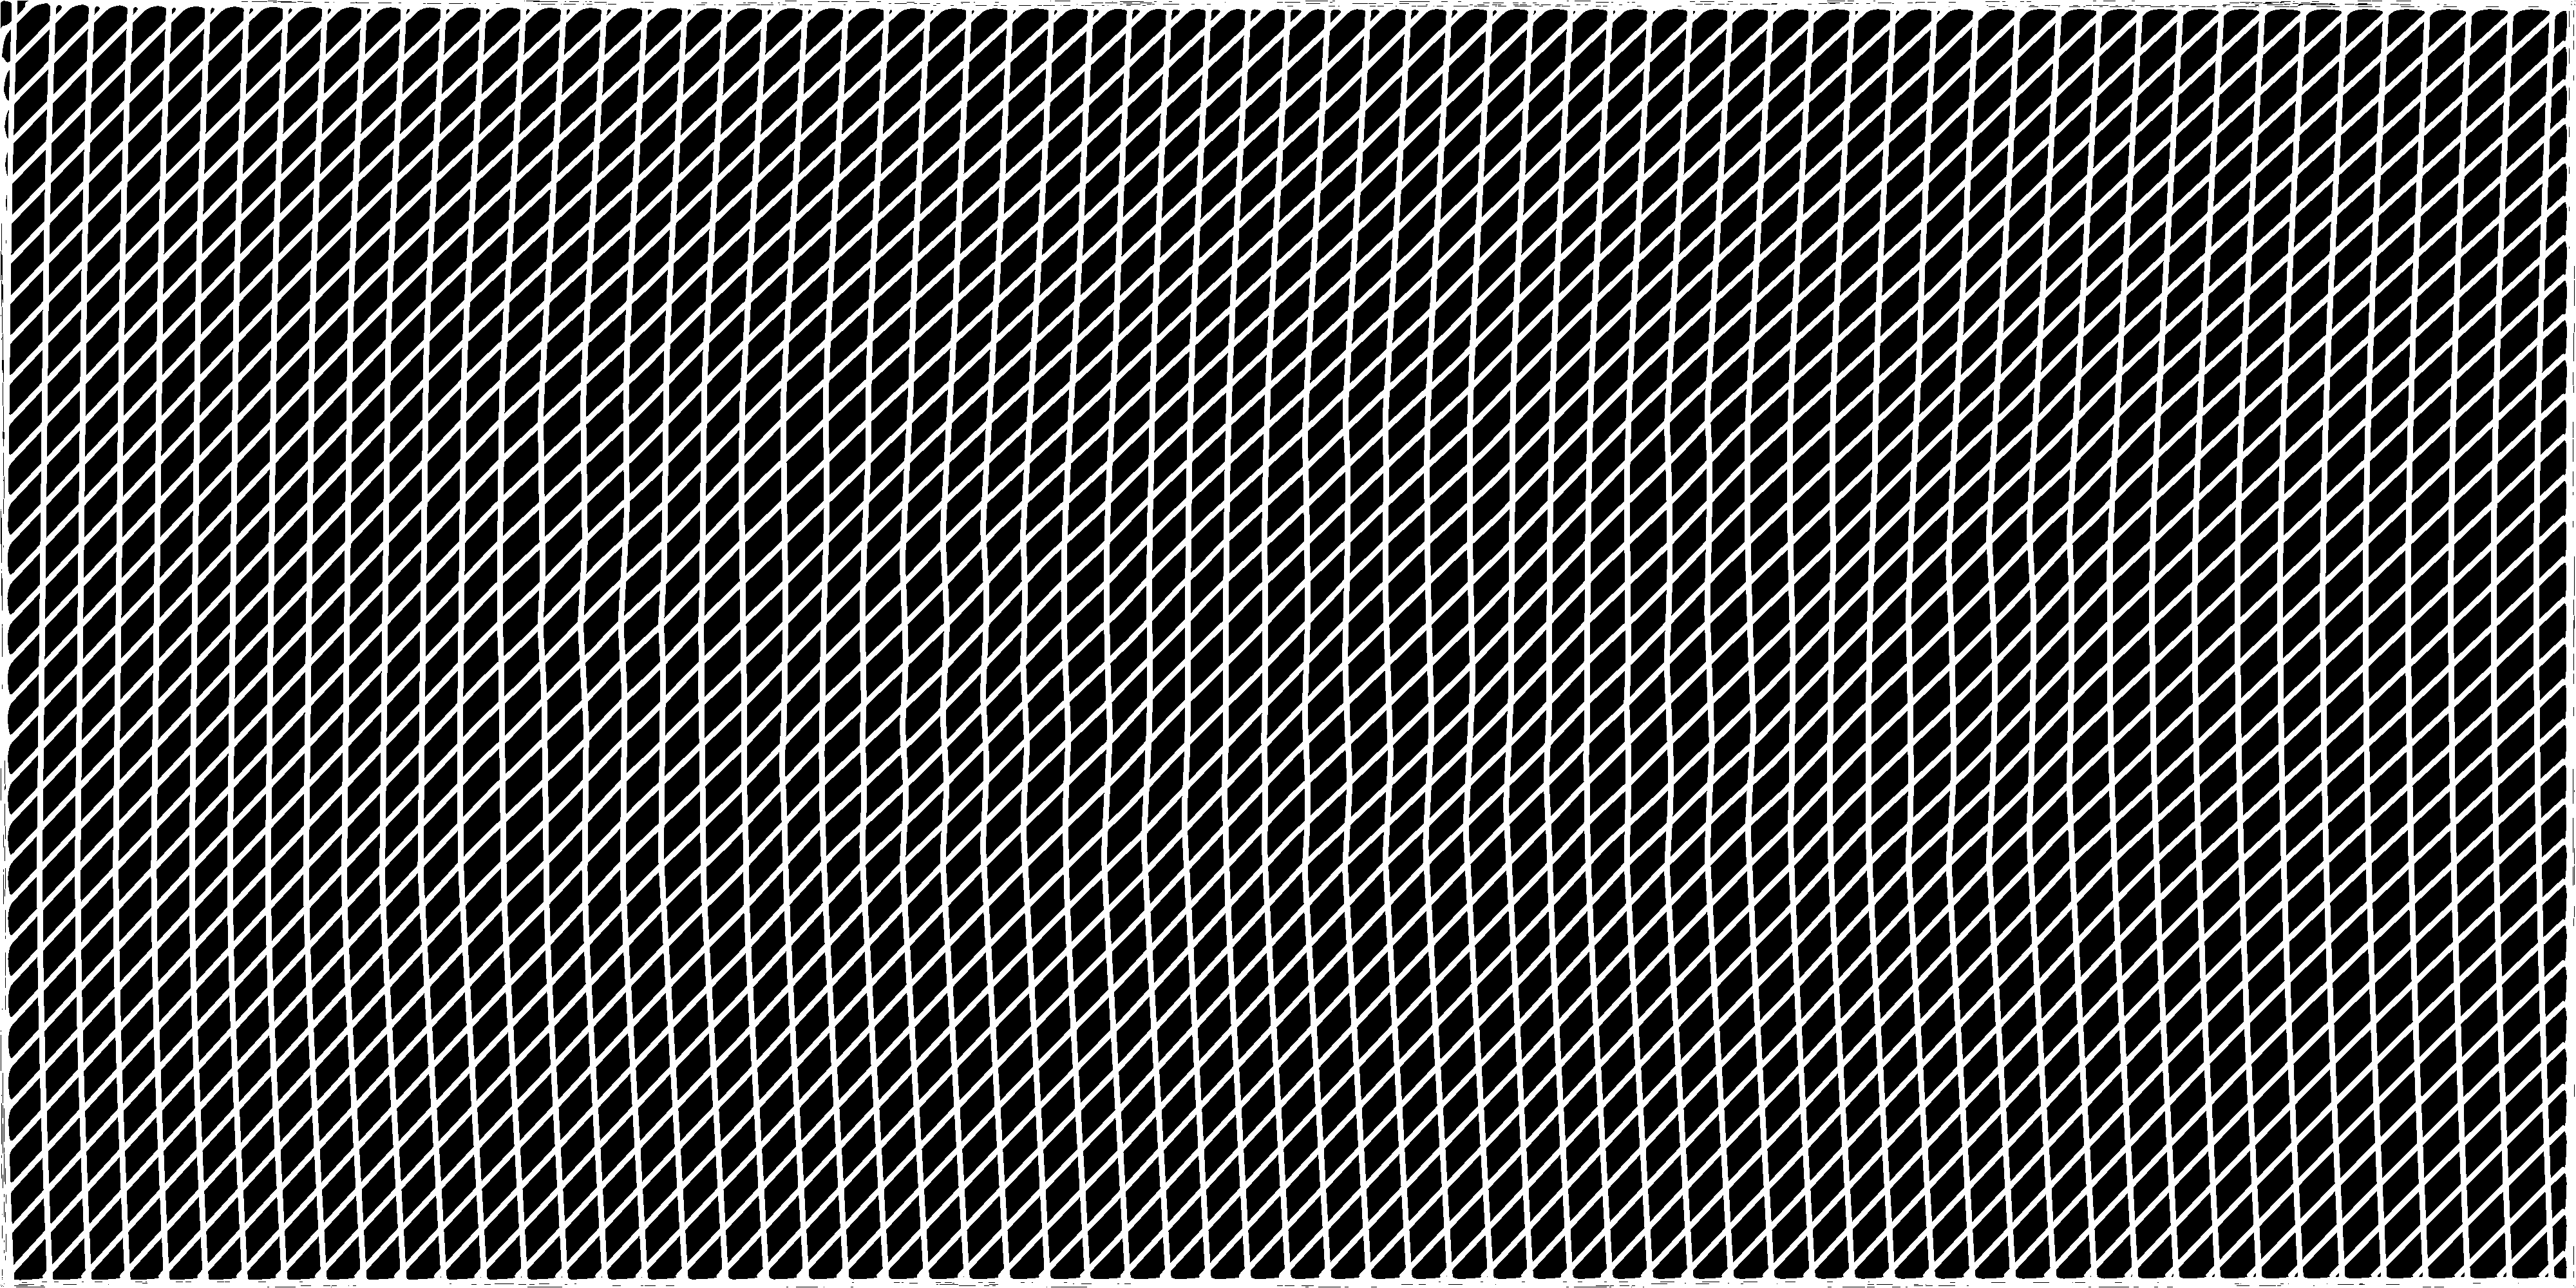

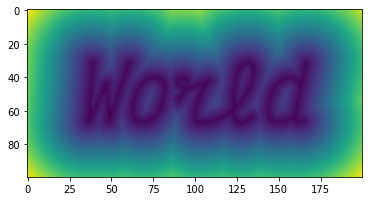

In [246]:
import skfmm
ds = skfmm.distance(0.5-(np.array(img1)/255).astype(np.float32), dx=1)
ds /= ds.max()
ds -= 0.5
plt.imshow(ds)

fd = scalefield(ds, 20)
gradx = np.linspace(0, 32*2, num=fd.shape[1])
fd2 = fd.copy()
for y in range(fd.shape[0]): fd2[y,:] -= gradx
contour = fieldtocontour(fd2, 1, 8)

ds = skfmm.distance(0.5-(np.array(img2)/255).astype(np.float32), dx=1)
ds /= ds.max()
ds -= 0.5
plt.imshow(ds)

fd = scalefield(ds, 20)
gradx = np.linspace(0, 32*2, num=fd.shape[1]) + 0.5
grady = np.linspace(0, 32*2 * (H/W), num=fd.shape[0])
fd2 = fd.copy()
for y in range(fd.shape[0]): fd2[y,:] -= gradx
for x in range(fd.shape[1]): fd2[:,x] -= grady
contour |= fieldtocontour(fd2, 1, 8)

img = Image.fromarray(contour)
img

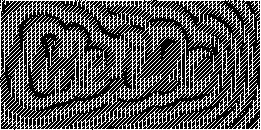

In [18]:
sx,sy = img.size
s = 15.3
img.resize((int(sx/s), int(sy/s)), resample=Image.Resampling.BICUBIC)

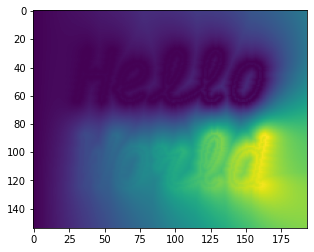

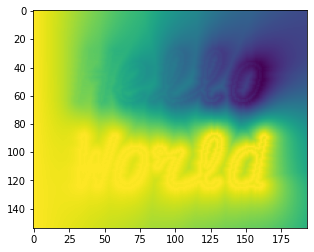

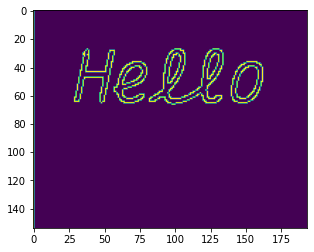

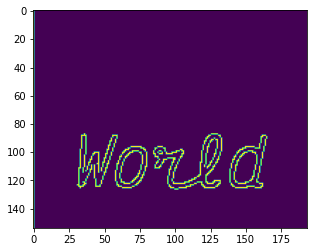

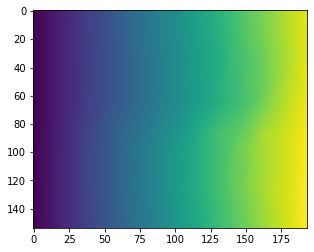

In [1083]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

from functools import reduce
from skimage import feature
from scipy.interpolate import interp2d
import skfmm

@jit(float64[:,:](float64[:,:]))
def gradientfield64(field):
    dfield = np.zeros(field.shape, dtype=np.float64)
    for y in range(1,field.shape[0]-1):
        for x in range(1,field.shape[1]-1):
            dy = (field[y+1,x] - field[y-1,x])/2
            dx = (field[y,x+1] - field[y,x-1])/2
            l = (dy*dy + dx*dx)**0.5
            if l < 0.001: continue
            dfield[y,x] = dx / l
    return dfield

nframes = 4
gif = Image.open("horse.gif")
gx,gy = gif.size
frames = [(lambda _: gif.copy().convert("L").resize((gx//2, gy//2)))(gif.seek(int(gif.n_frames/nframes * i))) for i in range(nframes)]

nframes = 2
gx,gy = img1.size
globimg = np.zeros((gy*2 - 40, gx), dtype=np.float64)
gimg1 = globimg.copy(); gimg1[:gy,:] = img1
gimg2 = globimg.copy(); gimg2[-gy:,:] = img2
frames = [gimg1, gimg2]

edges = [feature.canny(np.array(f), sigma=1)[3:-3,3:-3] for f in frames]
plt.imshow(reduce(lambda x,y: x | y, edges))
edges = [e.astype(np.float64) for e in edges]

sy,sx = edges[0].shape
bounds = np.zeros((sy,sx), dtype=np.float64)
bounds[0,:] = 1; bounds[-1,:] = 1; bounds[:,0] = 1; bounds[:,-1] = 1

getgrad = lambda i: np.linspace(0, 64+8*i, num=sx)
allgrads = np.array([getgrad(i) for i in range(nframes)])

sdfs = np.array([skfmm.distance(1.-e, dx=1) for e in edges])
#sdfs = np.array([skfmm.distance(np.array(f).astype(np.uint64)/255, dx=1) for f in frames])
sdfsdx = np.array([gradientfield64(f) for f in sdfs])

@jit(float64[:](float64[:]))
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

@jit(float64(float64, float64, float64))
def smoothstep(l,h,x):
    if x < l: return 0
    if x > h: return 1
    x = (x-l)/(h-l)
    return x*x*(3-2*x)

@jit(float64[:,:]())
def genfield():
    f = np.zeros((sy,sx), dtype=np.float64)
    for y in range(sy):
        for x in range(sx):
            ds = [sdfs[i,y,x] for i in range(len(sdfs))]
            nx = [x - ds[i] * sdfsdx[i,y,x] for i in range(len(ds))]
            #gs = [(nx[i]%1) * allgrads[i, int(nx[i])] + (1 - nx[i]%1) * allgrads[i, int(nx[i])+1]
            #     for i in range(len(nx)) 
            #]
            gs = [allgrads[i, x] for i in range(len(nx))]
            md = min(ds); mi = ds.index(md)
            if md < 0.01: f[y,x] = allgrads[mi, x]; continue
            md2 = sorted(ds)[1]; mi2 = ds.index(md2)
            #s = smoothstep(0,1,md / (md + md2))
            s = md / (md + md2)
            g = s * gs[mi2] + (1 - s)*gs[mi] 
            #ds = np.array(ds) / max(ds)
            #ds = [np.exp(-m*10) for m in ds]
            #wei = softmax(np.array(ds))
            #ds = [1/d for d in ds]
            #wei = np.array(ds) / sum(ds)
            #g = sum([wei[i]*gs[i] for i in range(len(gs))])
            f[y,x] = g
    return f

field = genfield()
plt.imshow(field - getgrad(0))
plt.show()
plt.imshow(field - getgrad(1))
plt.show()
plt.imshow(abs(field - getgrad(0)) < .01)
plt.show()
plt.imshow(abs(field - getgrad(1)) < .01)
plt.show()

plt.imshow(field)

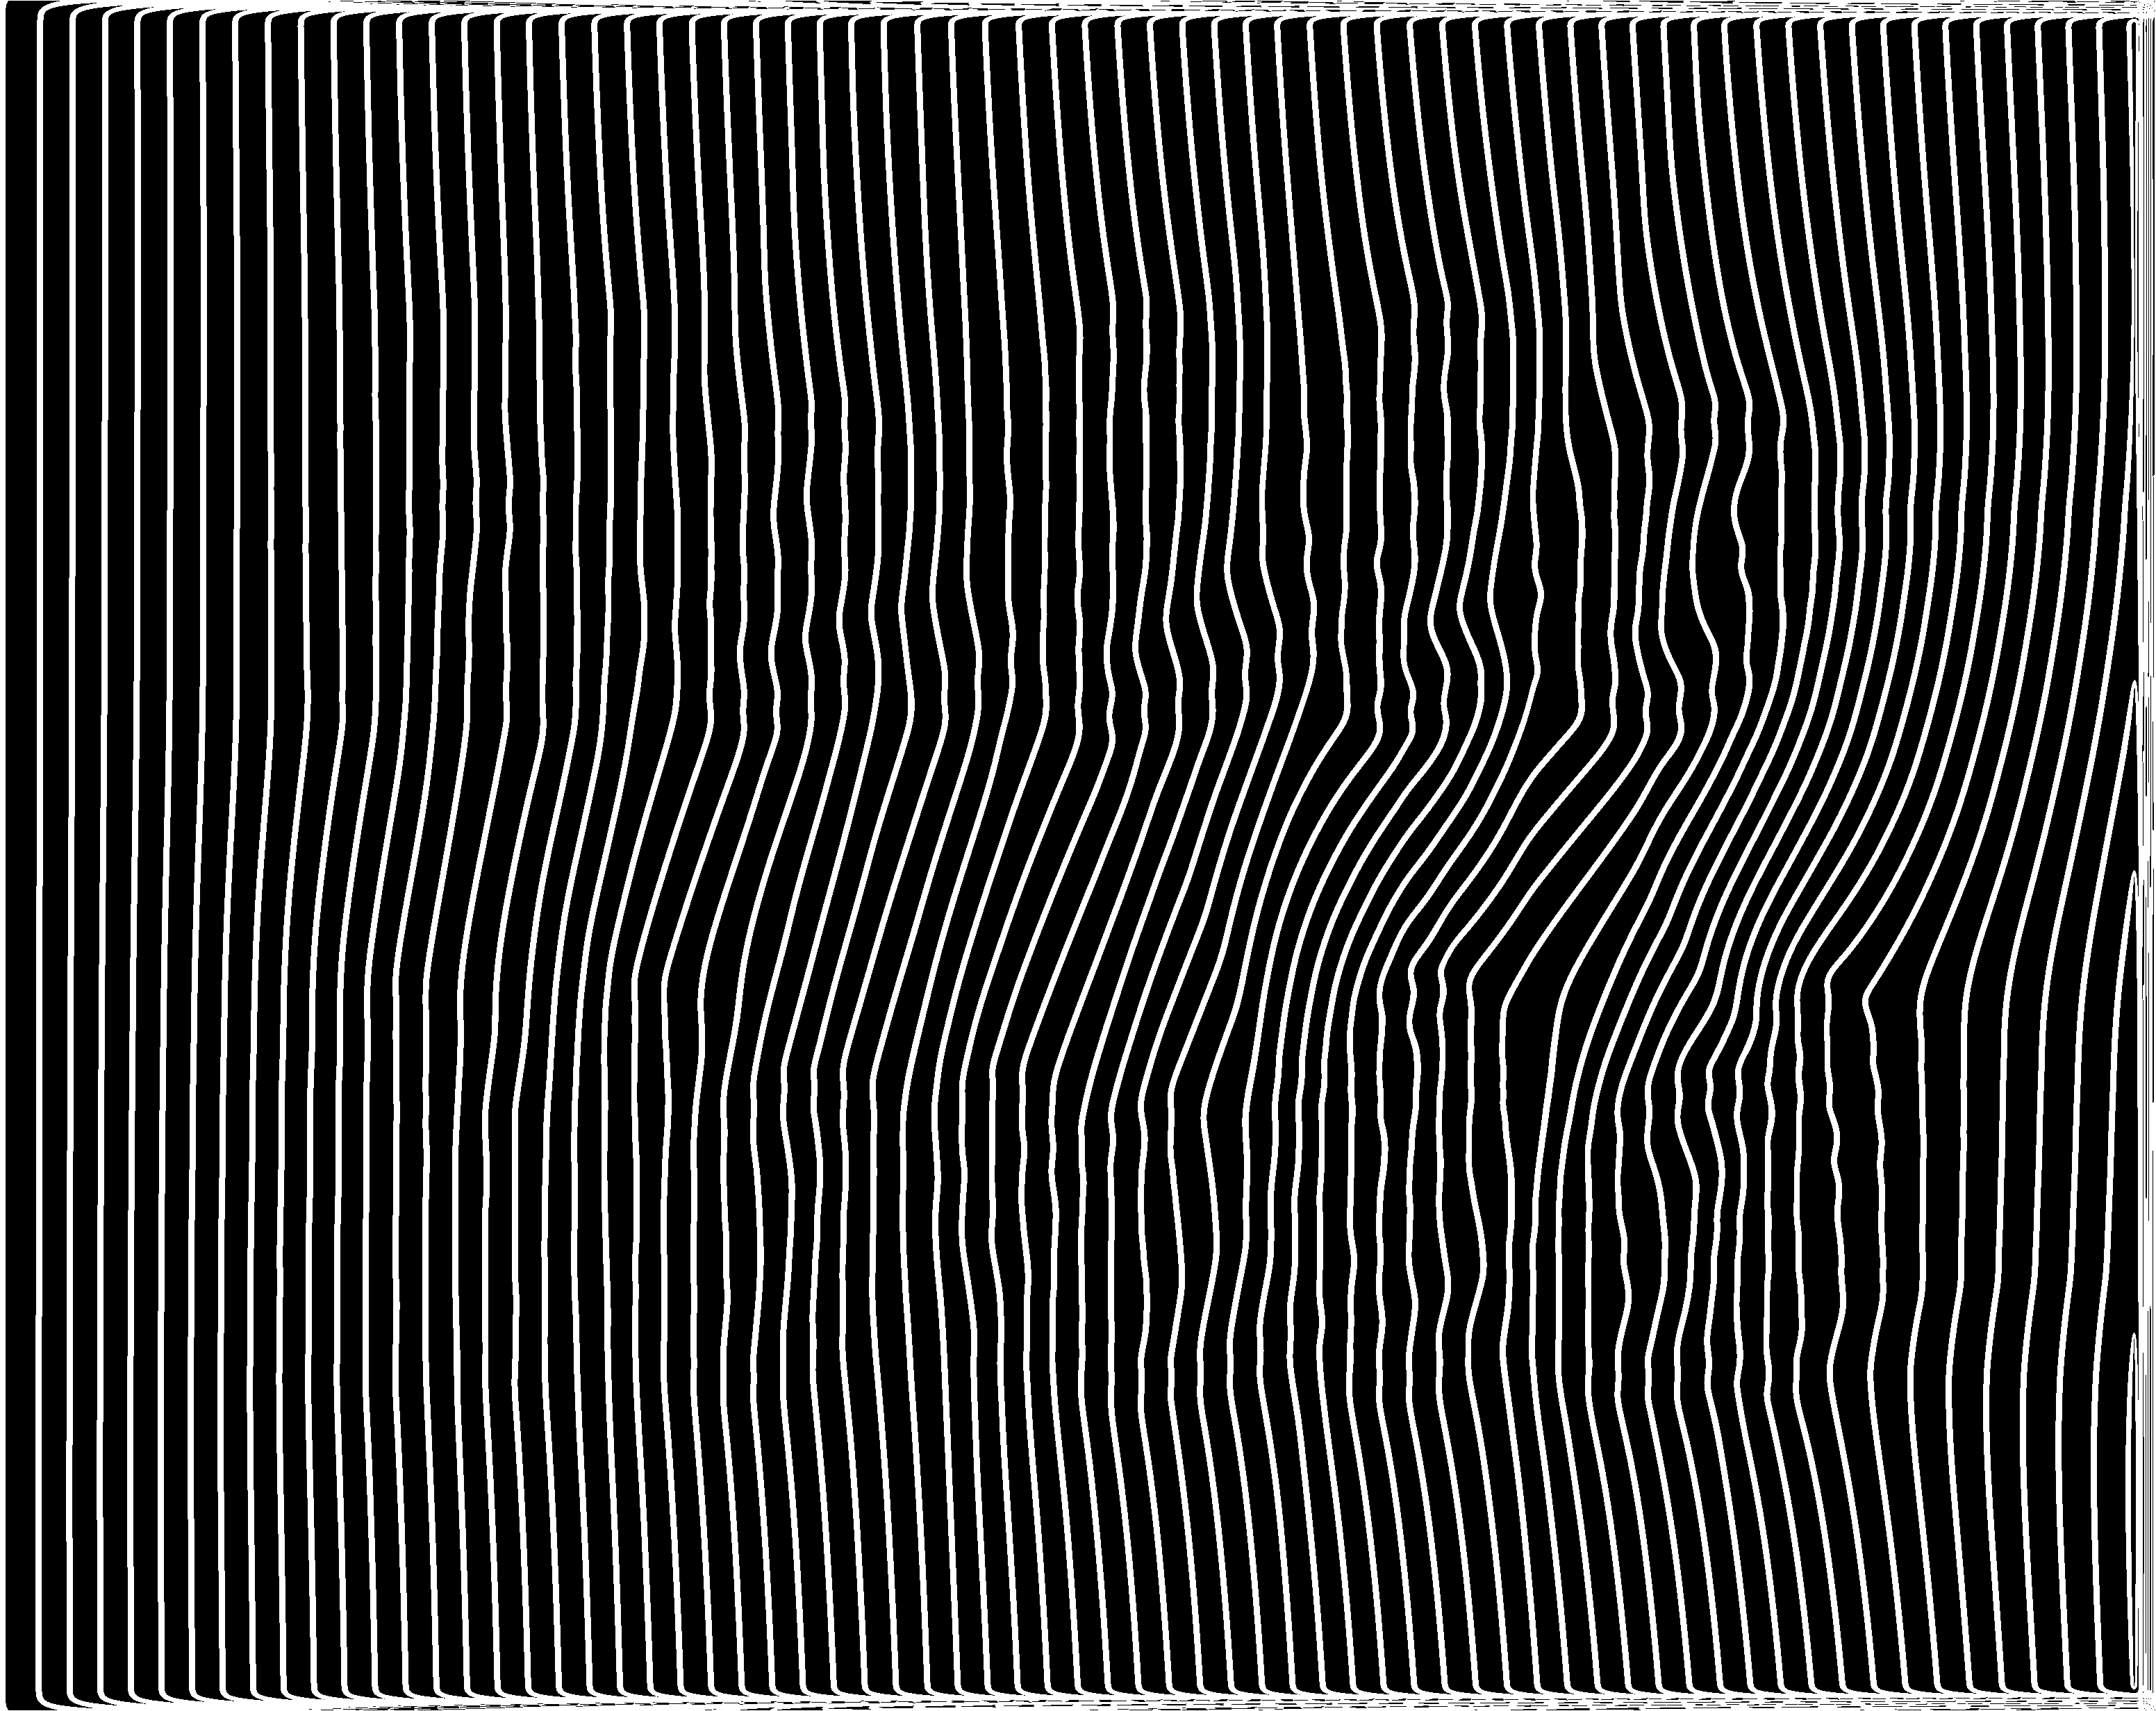

In [1091]:
fd = scalefield(field, 16)
contour = fieldtocontour(fd, 1, 8, 10)

fd2 = fd * 0
gradx = np.linspace(0, 32, num=fd.shape[1])
for y in range(fd.shape[0]): fd2[y,:] -= gradx
#contour |= fieldtocontour(fd2, 1, 4)
img = Image.fromarray(contour)
img

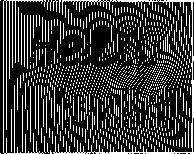

In [1092]:
sx,sy = img.size
s = 16
img.resize((int(sx/s), int(sy/s)), resample=Image.Resampling.BICUBIC)

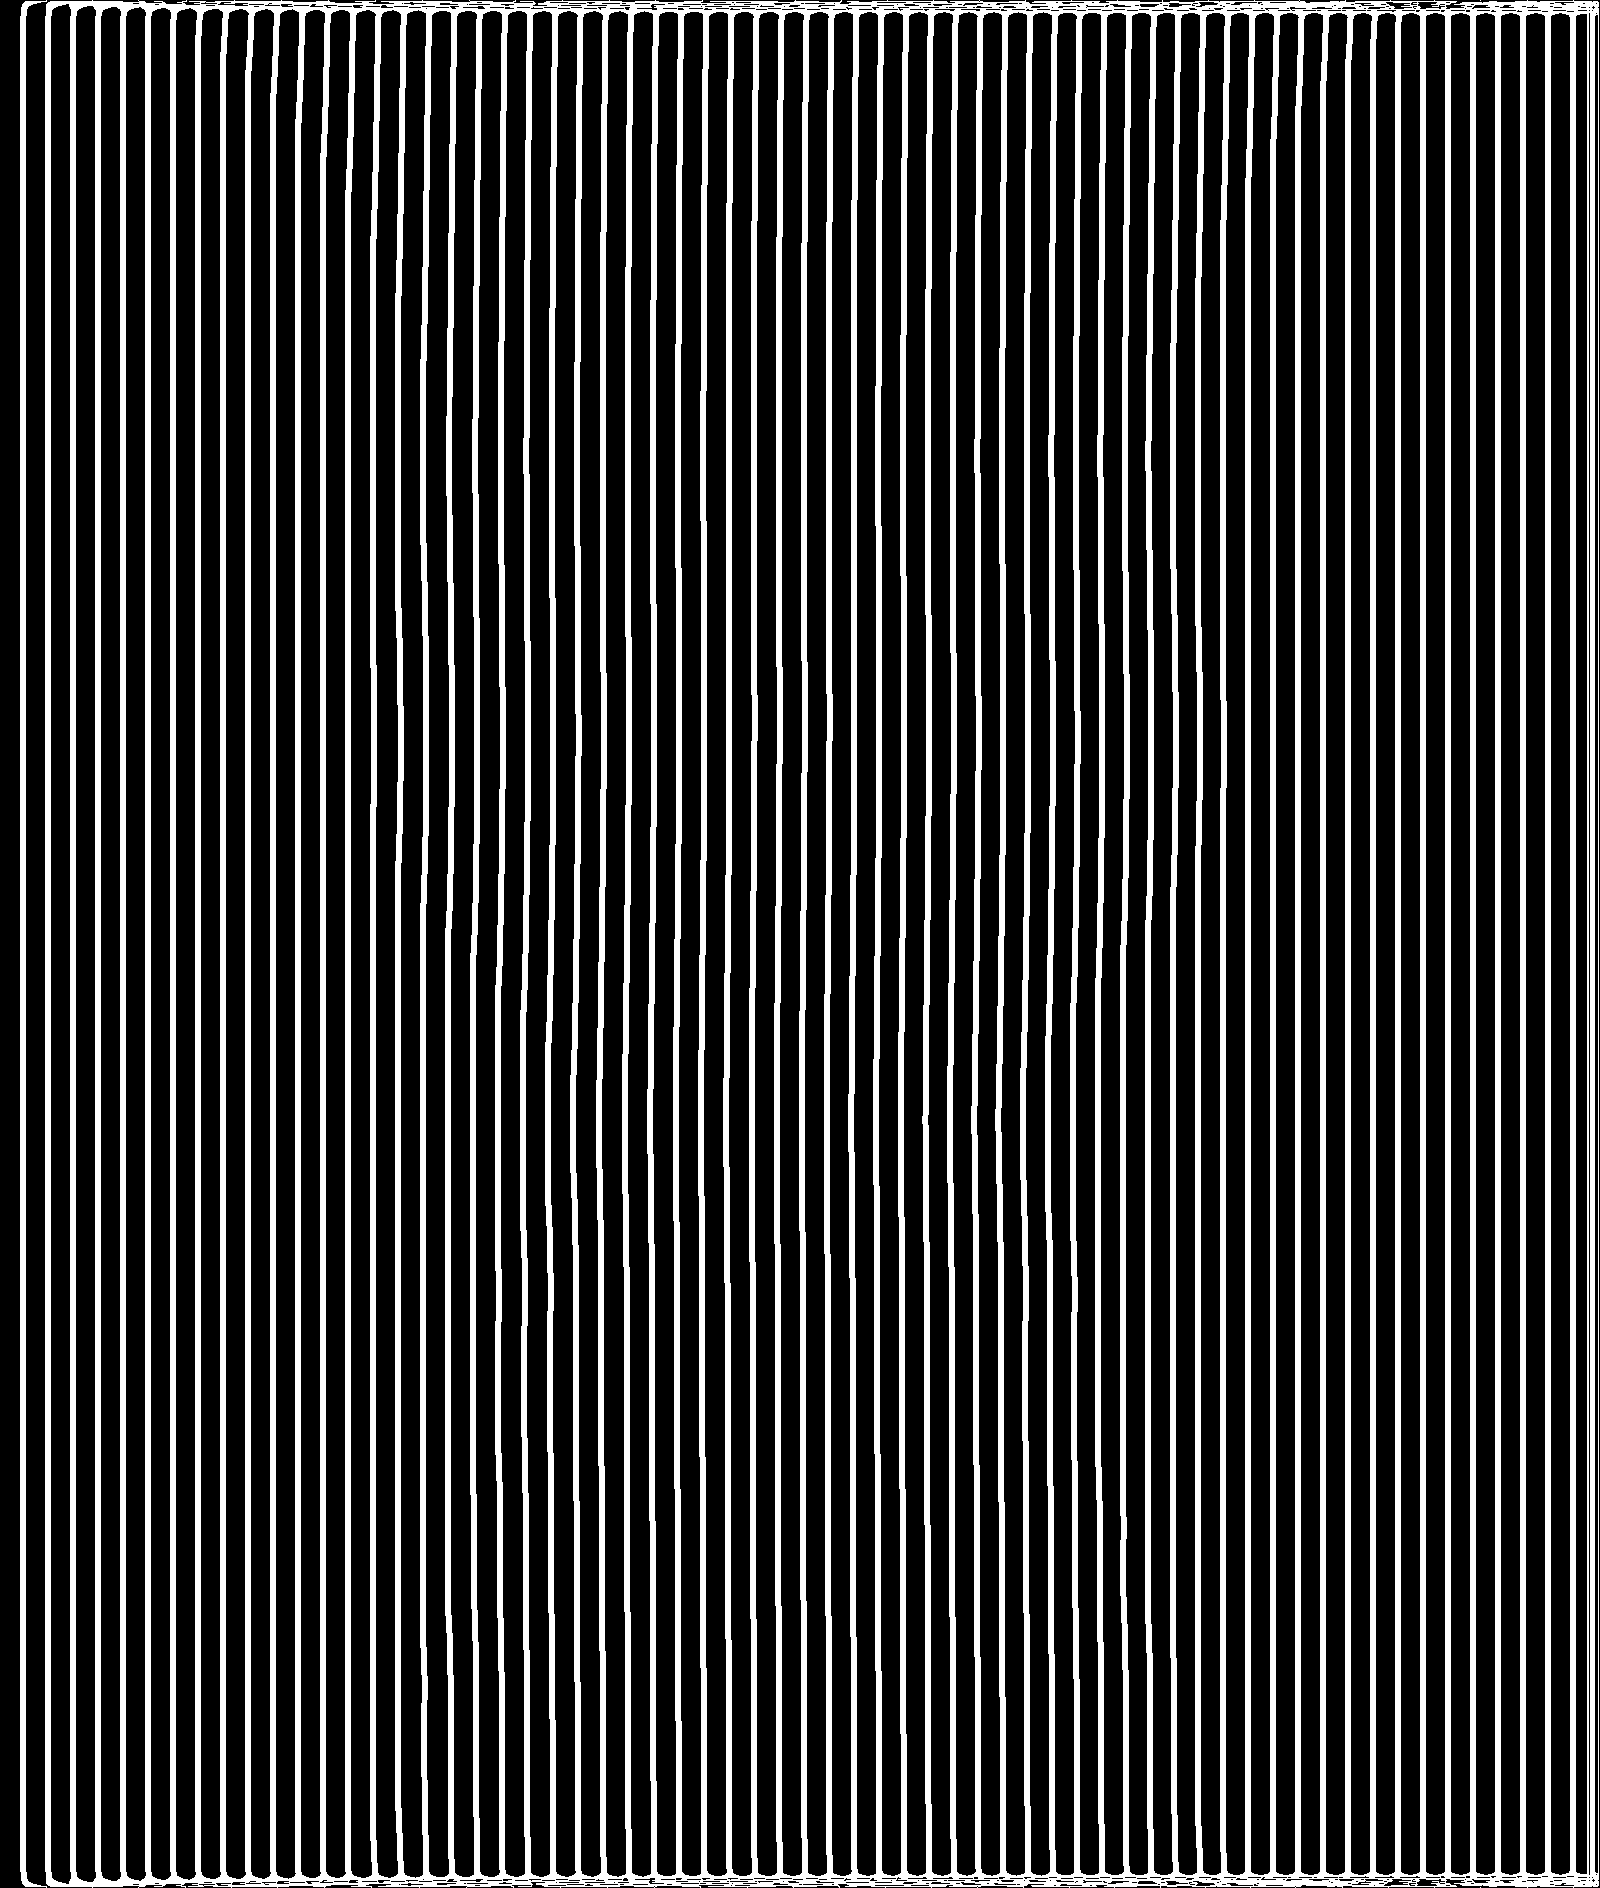

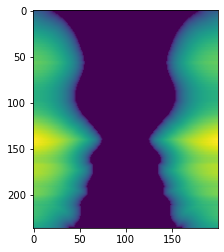

In [128]:
img = Image.open("facevase.png")
arr = np.array(img)[4:-3,:]
arr[arr > 0] = 255

import skfmm
vasesdfflat = skfmm.distance(0.5-(arr/255).astype(np.float32), dx=1)
vy,vx = vasesdfflat.shape
plt.imshow(vasesdfflat)

vasesdf = np.zeros((vy,vx), dtype=np.float64)
for y in range(vy):
    row = np.zeros(vx, dtype=np.float64)
    data = vasesdfflat[y,:]
    r = np.nonzero(data <= 0)[0].min()
    row[data <= 0] = ((vy//2 - r)**2 - (vy//2 - r - abs(data[data <= 0]))**2)**0.5
    vasesdf[y,:] = row
plt.imshow(vasesdf)

vasesdf2 = np.zeros((vy,vx), dtype=np.float64)
for y in range(vy):
    row = np.zeros(vx, dtype=np.float64)
    data = vasesdfflat[y,:]
    r = np.nonzero(data <= 0)[0].min()
    row[data >= 0] = (r**2 - (r - data[data >= 0])**2)**0.5
    vasesdf2[y,:] = row
plt.imshow(vasesdf2)

fincon = vasesdf

fd = scalefield(fincon, 8)
gradx = np.linspace(0, 32*32*16, num=fd.shape[1])
for y in range(fd.shape[0]): fd[y,:] -= gradx
contour = fieldtocontour(fd, 256, 5)

img = Image.fromarray(contour)
img